In [54]:
# cell 1
import os
import time
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from mplfinance.original_flavor import candlestick_ohlc

# ensure output folder
os.makedirs("scanner_output", exist_ok=True)

def compute_rsi(close, period=14):
    delta = close.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# ————————————— Compute MACD —————————————
def compute_macd(df, fast=12, slow=26, signal=9):
    ema_fast   = df["close"].ewm(span=fast,  adjust=False).mean()
    ema_slow   = df["close"].ewm(span=slow,  adjust=False).mean()
    macd_line  = ema_fast - ema_slow
    sig_line   = macd_line.ewm(span=signal, adjust=False).mean()
    hist       = macd_line - sig_line
    df["macd"]         = macd_line
    df["macd_signal"]  = sig_line
    df["macd_hist"]    = hist
    return df

def volume_metrics(df, vol_spike_ratio=1.5, vol_avg_window=20):
    df["avg_vol"]   = df["volume"].rolling(vol_avg_window, min_periods=1).mean()
    df["vol_spike"] = df["volume"] > vol_spike_ratio * df["avg_vol"]
    return df

def local_extrema(df, kind="min", order=5):
    func = np.less_equal if kind=="min" else np.greater_equal
    idx  = argrelextrema(df["close"].values, func, order=order)[0]
    return df.iloc[idx]

def find_trendlines(df, extrema, tolerance=1.5, min_touches=3):
    x = extrema.index.to_numpy(dtype=float)
    y = extrema["close"].to_numpy(dtype=float)
    lines = []
    n = len(x)
    if n < 2:
        return lines

    for i in range(n - 1):
        for j in range(i + 1, n):
            x1, x2 = x[i], x[j]
            y1, y2 = y[i], y[j]
            if x2 == x1:
                continue
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1

            # which extrema lie within tolerance of the line?
            mask = np.abs(y - (m * x + b)) < tolerance
            touches = int(mask.sum())
            if touches < min_touches:
                continue

            # compute span = max(x[mask]) - min(x[mask])
            # old: span = float(x[mask].ptp())
            span = float(np.ptp(x[mask]))

            lines.append({
                "slope":     float(m),
                "intercept": float(b),
                "touches":   touches,
                "span":      span
            })

    return lines

def signal_on_last(df, lines, is_support=True):
    """Returns list of (type,m,b,price_today)"""
    sigs = []
    c = df["close"].to_numpy(dtype=float)
    if c.size<2: return sigs
    p_yest, p_today = c[-2], c[-1]
    i_yest, i_today = c.size-2, c.size-1
    for L in lines:
        m,b = L if isinstance(L, tuple) else (L["slope"],L["intercept"])
        ly = m*i_yest + b
        lt = m*i_today + b
        if is_support and p_yest<ly and p_today>lt:
            sigs.append(("Buy", m,b, float(p_today)))
        if not is_support and p_yest>ly and p_today<lt:
            sigs.append(("Sell",m,b, float(p_today)))
    return sigs

def backtest_flip(signals, closes):
    c = closes.to_numpy(dtype=float)
    if c.size<2 or not signals:
        return dict(trades=0,
                    win_rate=np.nan,
                    cum_ret=0.0,
                    buy_hold=(c[-1]-c[0])/c[0]*100 if c.size>1 else 0.0)
    sigs = sorted(signals, key=lambda s:s[3])
    pos = None; entry=None; returns=[]
    for _,typ,m,b, _ in [(s[0],s[0],s[1],s[2],s[3]) for s in sigs]:
        # always evaluate exit at last price
        px = c[-1]
        if pos is None:
            pos = typ
            entry = px
        else:
            ret = (px-entry)/entry if pos=="Buy" else (entry-px)/entry
            returns.append(ret)
            pos = typ; entry=px
    # final exit
    final = c[-1]
    returns.append((final-entry)/entry if pos=="Buy" else (entry-final)/entry)
    wins = [r for r in returns if r>0]
    return dict(trades=len(returns),
                win_rate=len(wins)/len(returns)*100,
                cum_ret=(np.prod([1+r for r in returns])-1)*100,
                buy_hold=(c[-1]-c[0])/c[0]*100)


In [40]:
import yfinance as yf

tickers = ["AAPL","NVDA","SPY","PLTR"]
data = {}

for tk in tickers:
    df = (
        yf.download(tk, period="6mo", interval="1d", progress=False)
          .dropna()
          .reset_index()                         # pull “Date” back out of the index
    )
    # if you want to use adjusted-close as your “close” price:
    # df["close"] = df["adj_close"]
    # df = df.drop(columns="adj_close")
    
    # tack on a ticker column
    df["ticker"] = tk
    
    # reorder however you like
    df.columns = ['date', 'close', 'high', 'low', 'open', 'volume', 'stock']
    
    data[tk] = df

# now
data["AAPL"].head()


,date,close,high,low,open,volume,stock
0,2024-10-23,230.253235,234.623621,227.259823,233.565951,52287000,AAPL
1,2024-10-24,230.063660,230.313111,227.908400,229.474944,31109500,AAPL
2,2024-10-25,230.901810,232.707832,229.065854,229.235479,38802300,AAPL
3,2024-10-28,232.887436,234.214517,232.039312,232.807625,36087100,AAPL
4,2024-10-29,233.156845,233.815399,231.809819,232.588105,35417200,AAPL


In [72]:
# In [5]: find extrema & trendlines for AAPL
df["rsi_14"] = compute_rsi(df["close"], period=14)
df["rsi_signal"] = np.where(df["rsi_14"] < 30, "oversold",
                     np.where(df["rsi_14"] > 70, "overbought", "neutral"))

df = compute_macd(df)
df["macd_cross"] = np.where(
    (df["macd"].shift(1) < df["macd_signal"].shift(1)) &
    (df["macd"]     > df["macd_signal"]),
    "bull_cross",
    np.where(
        (df["macd"].shift(1) > df["macd_signal"].shift(1)) &
        (df["macd"]     < df["macd_signal"]),
        "bear_cross", ""
    )
)

df = volume_metrics(df)

# 5) find trendlines
lows      = local_extrema(df, "min", order=5)
highs     = local_extrema(df, "max", order=5)
sup_cands = find_trendlines(df, lows,  tolerance=1.5, min_touches=3)
res_cands = find_trendlines(df, highs, tolerance=1.5, min_touches=3)
sup_cands.sort(key=lambda L: (L["touches"], L["span"]), reverse=True)
res_cands.sort(key=lambda L: (L["touches"], L["span"]), reverse=True)
top_sup = sup_cands[:2]
top_res = res_cands[:2]
print("Top support lines:",    top_sup)
print("Top resistance lines:", top_res)

# 6) per-row signals
trend_signals = []
for i in range(len(df)):
    slice_df = df.iloc[: i+1]
    sup_hit = bool(signal_on_last(slice_df, top_sup, True))
    res_hit = bool(signal_on_last(slice_df, top_res, False))
    if sup_hit:
        trend_signals.append("Buy")
    elif res_hit:
        trend_signals.append("Sell")
    else:
        trend_signals.append("")
df["trendline_signal"] = trend_signals

df["composite_signal"] = ""  # default

# Buy when trendline=Buy AND MACD bull_cross AND RSI oversold
buy_mask = (
    (df["trendline_signal"]=="Buy") &
    (df["macd_cross"]       =="bull_cross") &
    (df["rsi_14"]           < 30)
)
df.loc[buy_mask, "composite_signal"] = "Buy"

# Sell when trendline=Sell AND MACD bear_cross AND RSI overbought
sell_mask = (
    (df["trendline_signal"]=="Sell") &
    (df["macd_cross"]        =="bear_cross") &
    (df["rsi_14"]            > 70)
)
df.loc[sell_mask, "composite_signal"] = "Sell"

# 7) composite signal logic
sup_break     = bool(signal_on_last(df, top_sup, True))
res_break     = bool(signal_on_last(df, top_res, False))
macd_bull     = (df["macd_cross"].iat[-1] == "bull_cross")
macd_bear     = (df["macd_cross"].iat[-1] == "bear_cross")
rsi_oversold  = (df["rsi_14"].iat[-1] < 30)
rsi_overbought= (df["rsi_14"].iat[-1] > 70)

signal = None
if sup_break and macd_bull and rsi_oversold:
    signal = "Buy"
elif res_break and macd_bear and rsi_overbought:
    signal = "Sell"

if signal:
    price = sup_break and signal_on_last(df, top_sup, True)[0][3] \
          or signal_on_last(df, top_res, False)[0][3]
    print(f"🚀 Composite {signal} signal at {price:.2f}")
else:
    print("No composite signal on the last bar.")


Top support lines: [{'slope': -0.39009931610851756, 'intercept': 144.11202091124, 'touches': 5, 'span': 96.0}, {'slope': -0.4000856081644694, 'intercept': 145.32036225001016, 'touches': 4, 'span': 96.0}]
Top resistance lines: [{'slope': -0.35068184988839285, 'intercept': 155.2864270891462, 'touches': 4, 'span': 85.0}, {'slope': -0.34995007870802236, 'intercept': 155.26520572491546, 'touches': 4, 'span': 85.0}]
No composite signal on the last bar.


In [73]:
df[df['date']>='2024-11']

,date,close,high,low,open,volume,stock,rsi_14,rsi_signal,avg_vol,vol_spike,macd,macd_signal,macd_hist,macd_cross,trendline_signal,composite_signal
7,2024-11-01,135.378220,137.287916,134.548367,134.678335,207127800,NVDA,57.737370,neutral,2.063966e+08,False,-0.638617,-0.091494,-0.547123,,,
8,2024-11-04,136.028122,138.937658,135.548203,137.187939,187528200,NVDA,59.156386,neutral,2.043001e+08,False,-0.780653,-0.229326,-0.551327,,,
9,2024-11-05,139.887497,140.347414,137.307910,137.427886,160537400,NVDA,66.376271,neutral,1.999238e+08,False,-0.575168,-0.298494,-0.276673,,,
10,2024-11-06,145.586563,146.466426,141.937157,142.936996,242043900,NVDA,73.754239,overbought,2.037529e+08,False,0.047006,-0.229394,0.276400,bull_cross,Buy,
11,2024-11-07,148.856064,148.906044,146.146493,146.366459,207323300,NVDA,76.887523,overbought,2.040505e+08,False,0.794743,-0.024567,0.819310,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2025-04-16,104.489998,106.790001,100.449997,104.550003,397016900,NVDA,43.915572,neutral,3.313529e+08,False,-2.995533,-3.847360,0.851827,,,
120,2025-04-17,101.489998,104.470001,100.050003,104.449997,290833400,NVDA,41.680674,neutral,3.334531e+08,False,-3.297720,-3.737432,0.439712,,,
121,2025-04-21,96.910004,99.440002,95.040001,98.769997,288501100,NVDA,38.462529,neutral,3.345532e+08,False,-3.862251,-3.762396,-0.099855,bear_cross,,
122,2025-04-22,98.889999,99.809998,97.279999,98.779999,237594100,NVDA,40.597821,neutral,3.350103e+08,False,-4.102584,-3.830433,-0.272151,,,


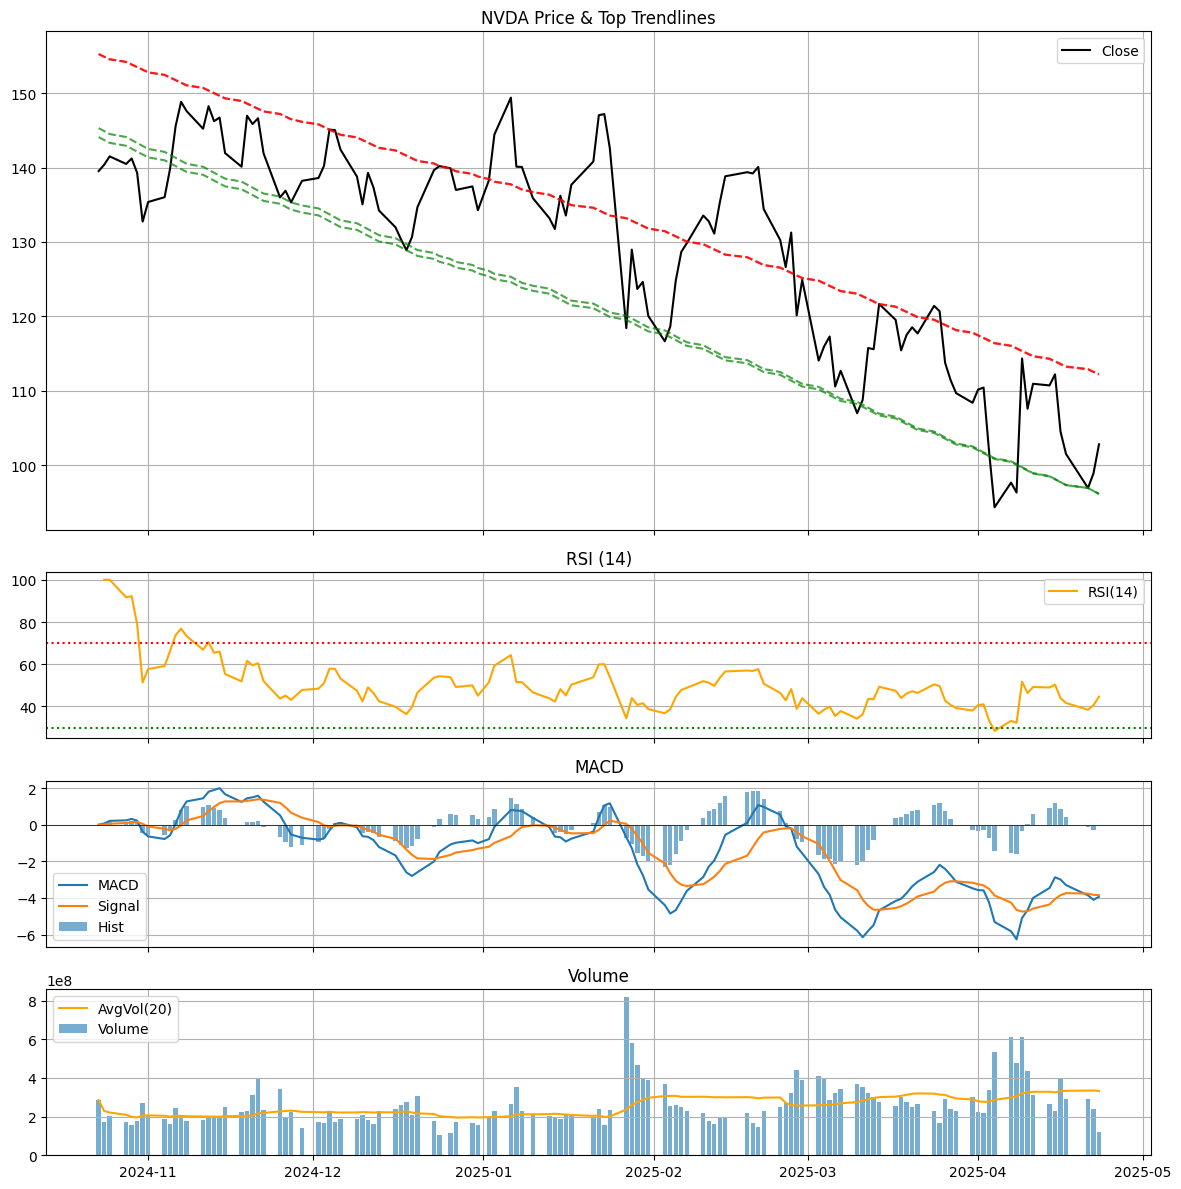

In [61]:
# create 4 rows: price, RSI, MACD, volume
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4, 1, figsize=(12, 12), sharex=True,
    gridspec_kw={"height_ratios": [3, 1, 1, 1]}
)

# — price + trendlines —
ax1.plot(df["date"], df["close"], color="black", label="Close")
for L in top_sup + top_res:
    m, b = L["slope"], L["intercept"]
    x = np.arange(len(df), dtype=float)
    ax1.plot(
        df["date"], m * x + b,
        linestyle="--",
        color="green" if L in top_sup else "red",
        alpha=0.7
    )
ax1.set_title(f"NVDA Price & Top Trendlines")
ax1.legend(); ax1.grid(True)

# — RSI —
ax2.plot(df["date"], df["rsi_14"], color="orange", label="RSI(14)")
ax2.axhline(70, color="red",   linestyle=":")
ax2.axhline(30, color="green", linestyle=":")
ax2.set_title("RSI (14)"); ax2.legend(); ax2.grid(True)

# — MACD —
ax3.plot(df["date"], df["macd"],        label="MACD")
ax3.plot(df["date"], df["macd_signal"], label="Signal")
# histogram as bar
ax3.bar(df["date"], df["macd_hist"], alpha=0.6, label="Hist")
ax3.axhline(0, color="black", linewidth=0.5)
ax3.set_title("MACD"); ax3.legend(); ax3.grid(True)

# — volume —
ax4.bar(df["date"], df["volume"],      alpha=0.6, label="Volume")
ax4.plot(df["date"], df["avg_vol"], color="orange", label="AvgVol(20)")
ax4.set_title("Volume"); ax4.legend(); ax4.grid(True)

# — last‐bar signal on price —
sup_sig = signal_on_last(df, top_sup, True)
res_sig = signal_on_last(df, top_res, False)
sig = (sup_sig + res_sig)[:1]
if sig:
    typ, *_ , price = sig[0]
    ax1.scatter(
        df["date"].iat[-1], price,
        marker="^" if typ=="Buy" else "v",
        color="green" if typ=="Buy" else "red",
        s=200, zorder=5, label=f"{typ} Signal"
    )
    ax1.legend()

plt.tight_layout()
plt.show()
